# Desafio 1
## Alumno: Maxim Dorogov

Consigna del desafio 2:
1. Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
1. Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
1. Graficarlos.
1. Obtener conclusiones.


In [60]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models.callbacks import CallbackAny2Vec
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np

## Datos

El dataset a utilizar es [Lovecraft Fiction](https://www.kaggle.com/datasets/bennijesus/lovecraft-fiction?resource=download), que contiene relatos, en idioma ingles, del autor H.P. Lovecraft.

In [8]:
# levantamos el archivo concat.txt el cual contiene todos los relatos concatenados.

DATA_PATH = 'data/concat.txt'

df = pd.read_csv(DATA_PATH, sep="/n", header=None)
df.head()
print(f'Cantidad de lineas: {len(df)}')

/tmp/ipykernel_13157/3355303101.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(DATA_PATH, sep="/n", header=None)


Cantidad de lineas: 45735


In [9]:
sentence_tokens = []
# Transformamos las oraciones en listas de palabras
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

sentence_tokens[:2]

[['high',
  'up',
  'crowning',
  'the',
  'grassy',
  'summit',
  'of',
  'a',
  'swelling',
  'mound',
  'whose',
  'sides',
  'are',
  'wooded',
  'near',
  'the',
  'base'],
 ['with',
  'the',
  'gnarled',
  'trees',
  'of',
  'the',
  'primeval',
  'forest',
  'stands',
  'the',
  'old',
  'chateau',
  'of',
  'my',
  'ancestors',
  'for',
  'centuries']]

In [40]:
class Callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self, log:bool=False):
        self.epoch = 0
        self.loss = list()
        self._log = log

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self._log:
            if self.epoch == 0:
                print('Loss after epoch {}: {}'.format(self.epoch, loss))
            else:
                print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss
        self.loss.append(loss - self.loss_previous_step if self.epoch > 1 else loss)

# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5, 
                window=2,
                vector_size=300,
                negative=20,    
                sg=1)  # modelo 0:CBOW  1:skipgram

In [41]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)
# Cantidad de palabras encontradas en el corpus
print("Cantidad de palabras distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de docs en el corpus: 45735
Cantidad de palabras distintas en el corpus: 10243


In [42]:
# Entrenamiento del modelo

loss_logger = Callback(log=False)

w2v_model.train(
    sentence_tokens,
    total_examples=w2v_model.corpus_count,
    epochs=10,
    compute_loss=True,
    callbacks=[loss_logger])

(4743281, 6838660)

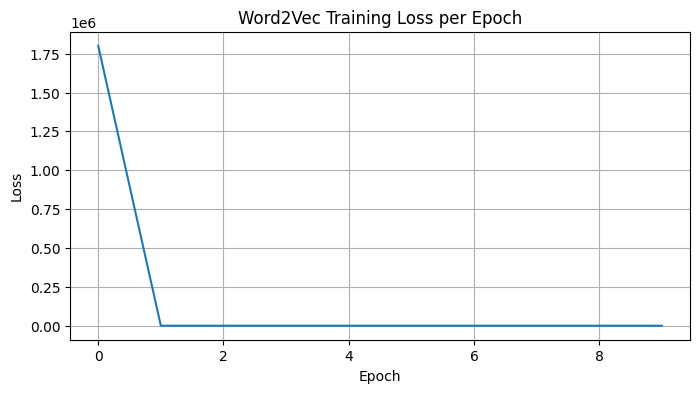

In [45]:
# Plot training loss curve
plt.figure(figsize=(8, 4))
plt.plot(loss_logger.loss)
plt.title('Word2Vec Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Se observa que el modelo converge rápidamente, luego de varias pruebas se decidió entrenar el modelo por 10 epochs.

In [63]:
words_of_interest = ['madness', 'university', 'ancient', 'cult']
non_existent_word = ['sadfr']

for word in words_of_interest:
    print(f'\nMost similar to "{word}":')
    for similar_word, similarity in w2v_model.wv.most_similar(word, topn=10):
        print(f'  {similar_word}: {similarity:.4f}')



Most similar to "madness":
  delirium: 0.7973
  folly: 0.7968
  sanity: 0.7941
  vengeance: 0.7855
  inmost: 0.7786
  supreme: 0.7723
  instincts: 0.7693
  serpents: 0.7692
  poetry: 0.7680
  aught: 0.7623

Most similar to "university":
  miskatonic: 0.8898
  school: 0.8207
  harvard: 0.8176
  widener: 0.8161
  museum: 0.8039
  newburyport: 0.8007
  library: 0.8002
  college: 0.7944
  american: 0.7863
  medical: 0.7824

Most similar to "ancient":
  venerable: 0.7055
  antique: 0.6978
  archaic: 0.6785
  old: 0.6568
  prehistoric: 0.6409
  centuried: 0.6409
  tottering: 0.6348
  hoary: 0.6329
  manuscripts: 0.6282
  isolated: 0.6280

Most similar to "cult":
  legend: 0.8002
  pnakotic: 0.7990
  arts: 0.7919
  manuscripts: 0.7907
  hyperborea: 0.7891
  racial: 0.7872
  hereditary: 0.7803
  tsathoggua: 0.7785
  catacombs: 0.7772
  workmanship: 0.7750


Podemos notar que en algunos casos las palabras similares son sinónimos o están relacionadas semánticamente, como "madness" y "insanity", o "university" y "college". Pero en otros casos la similitud solo tiene sentido dentro del contexto de los relatos de Lovecraft, como "university" y "miskatonic" ya que la Universidad de Miskatonic es una institución ficticia en los relatos de Lovecraft.

In [61]:
# También se pueden guardar los vectores y labels como tsv para graficar en
# http://projector.tensorflow.org/

vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("vectors.tsv", vectors, delimiter="\t")

with open("labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

![imagen](./images/image.png)